# Getting started with PPO and ProcGen

Here's a bit of code that should help you get started on your projects.

The cell below installs `procgen` and downloads a small `utils.py` script that contains some utility functions. You may want to inspect the file for more details.

In [ ]:
!pip install procgen
!wget https://raw.githubusercontent.com/nicklashansen/ppo-procgen-utils/main/utils.py
# !wget https://raw.githubusercontent.com/pokaxpoka/rad_procgen/346fb852fa16e739601ca998eebd1d56b95aa2e8/train_procgen/data_augs.py
# !wget https://raw.githubusercontent.com/hlynurarni/Deep_learning_02456_FProject/master/augmentation_scripts/TransformLayer.py?token=ACR4O3BQOPEZ5B7DO6MQUJ272TFA2

--2020-12-08 12:14:00--  https://raw.githubusercontent.com/nicklashansen/ppo-procgen-utils/main/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14807 (14K) [text/plain]
Saving to: ‘utils.py.2’

utils.py.2          100%[===================>]  14.46K  --.-KB/s    in 0s      

2020-12-08 12:14:00 (116 MB/s) - ‘utils.py.2’ saved [14807/14807]



Hyperparameters. These values should be a good starting point. You can modify them later once you have a working implementation.


In [ ]:
# Hyperparameters
total_steps = 1e4 # 8e6
num_envs = 32 # 32
num_levels = 100 # 10
num_steps = 256 # 256
num_epochs = 3 # 3
batch_size = 512 # 512
eps = .2 # .2
grad_eps = .5 # .5
value_coef = .5 # .5
entropy_coef = .01 # .01

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Network definitions. We have defined a policy network for you in advance. It uses the popular `NatureDQN` encoder architecture (see below), while policy and value functions are linear projections from the encodings. There is plenty of opportunity to experiment with architectures, so feel free to do that! Perhaps implement the `Impala` encoder from [this paper](https://arxiv.org/pdf/1802.01561.pdf) (perhaps minus the LSTM).

In [ ]:
# Add the necessary libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from utils import make_env, Storage, orthogonal_init
from time import time

In [ ]:
def imshow(img):
    """ show an image """
    plt.figure(figsize=(10,8))
    plt.imshow(np.transpose(img, (1, 2, 0)))

# Grayscaling

In [ ]:
# Randomly grascale an envorinment observation space, the p value can be adjusted for the probability of a figure being grascaled
class RandGray(object):
    def __init__(self,  
                 batch_size, 
                 p_rand=0.5,
                 *_args, 
                 **_kwargs):
        
        self.p_gray = p_rand
        self.batch_size = batch_size
        self.random_inds = np.random.choice([True, False], 
                                            batch_size, 
                                            p=[self.p_gray, 1 - self.p_gray])
        
    def grayscale(self, imgs):
        # imgs: b x h x w x c
        # the format is incorrect
        b, c, h, w = imgs.shape # format changed, hlynur
        imgs = imgs[:, 0, :, :] * 0.2989 + imgs[:, 1, :, :] * 0.587 + imgs[:, 2, :, :] * 0.114 
        imgs = np.tile(imgs.reshape(b,-1,h,w), (1, 3, 1, 1)) # .astype(np.uint8)
        return imgs

    def do_augmentation(self, images):
        # images: [B, C, H, W]
        bs, channels, h, w = images.shape
        # print(images.shape)
        if self.random_inds.sum() > 0:
            # print(self.random_inds)
            # print(sum(self.random_inds))
            # print(images[self.random_inds].shape)
            images[self.random_inds] =  self.grayscale(images[self.random_inds])

        return images
    
    def change_randomization_params(self, index_):
        self.random_inds[index_] = np.random.choice([True, False], 1, 
                                                    p=[self.p_gray, 1 - self.p_gray])
        
    def change_randomization_params_all(self):
        self.random_inds = np.random.choice([True, False], 
                                            self.batch_size, 
                                            p=[self.p_gray, 1 - self.p_gray])
        
    def print_parms(self):
        print(self.random_inds)


In [ ]:
games = ['coinrun','dodgeball']

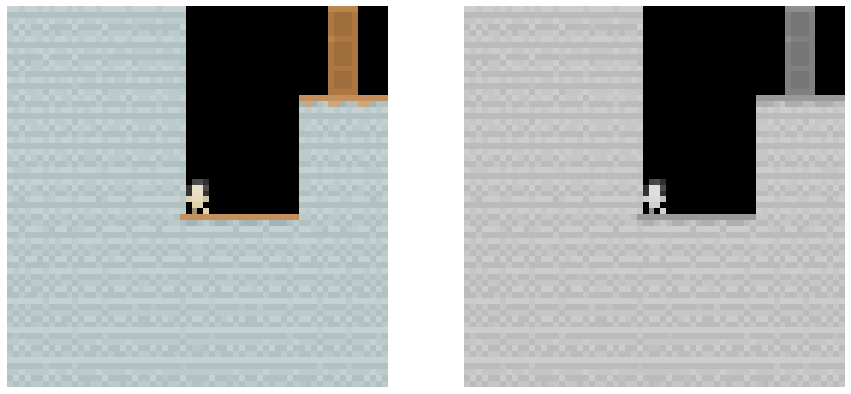

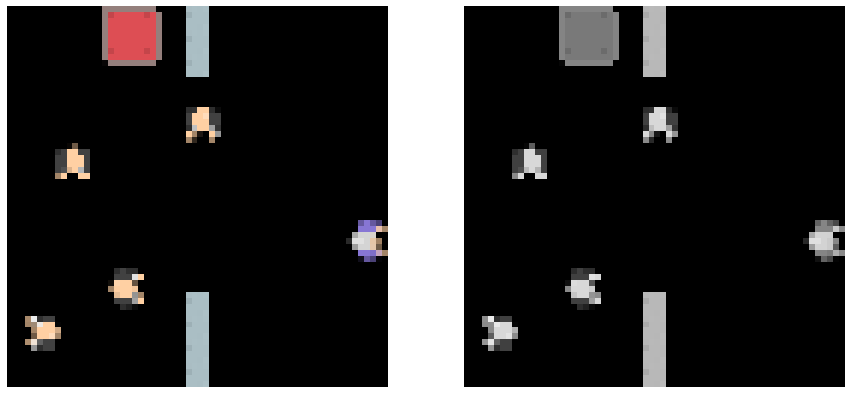

In [ ]:
# How to use the RandGray class
path = '/content/gdrive/MyDrive/Deep Learning Project 2020/data/aug_figures/'
for game in games:
    env = make_env(num_envs, num_levels=num_levels, env_name=game)
    nenv = env.num_envs # added
    obs = np.zeros((nenv,) + env.observation_space.shape, dtype=env.observation_space.dtype.name)
    obs[:] = env.reset()
    sample = obs[0,:,:,:]

    #  Plot the original observation
    plt.figure(figsize=(15,15))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(np.transpose(sample, (1, 2, 0)));


    # Do the augmentation
    augs_funcs = RandGray(batch_size=num_envs, p_rand=1) # added
    obs = augs_funcs.do_augmentation(obs)
    sample = obs[0,:,:,:]

    # Plot the augmented
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(np.transpose(sample, (1, 2, 0)));
    # plt.show()
    plt.savefig(f'{path}grayscale_{game}.png')

# Random Color Jitter

In [ ]:
#Trying to adjust the size of the random sample we are changing
# taken from: https://github.com/MishaLaskin/rad/blob/1246bfd6e716669126e12c1f02f393801e1692c1/TransformLayer.py#L87

# Repository has to be public to be able to import functions from it

import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import numpy as np
import numbers
import random
import time


def rgb2hsv(rgb, eps=1e-8):
    # Reference: https://www.rapidtables.com/convert/color/rgb-to-hsv.html
    # Reference: https://github.com/scikit-image/scikit-image/blob/master/skimage/color/colorconv.py#L287

    _device = rgb.device
    r, g, b = rgb[:, 0, :, :], rgb[:, 1, :, :], rgb[:, 2, :, :]

    Cmax = rgb.max(1)[0]
    Cmin = rgb.min(1)[0]
    delta = Cmax - Cmin

    hue = torch.zeros((rgb.shape[0], rgb.shape[2], rgb.shape[3])).to(_device)
    hue[Cmax== r] = (((g - b)/(delta + eps)) % 6)[Cmax == r]
    hue[Cmax == g] = ((b - r)/(delta + eps) + 2)[Cmax == g]
    hue[Cmax == b] = ((r - g)/(delta + eps) + 4)[Cmax == b]
    hue[Cmax == 0] = 0.0
    hue = hue / 6. # making hue range as [0, 1.0)
    hue = hue.unsqueeze(dim=1)

    saturation = (delta) / (Cmax + eps)
    saturation[Cmax == 0.] = 0.
    saturation = saturation.to(_device)
    saturation = saturation.unsqueeze(dim=1)

    value = Cmax
    value = value.to(_device)
    value = value.unsqueeze(dim=1)

    return torch.cat((hue, saturation, value), dim=1)#.type(torch.FloatTensor).to(_device)
    # return hue, saturation, value

def hsv2rgb(hsv):
    # Reference: https://www.rapidtables.com/convert/color/hsv-to-rgb.html
    # Reference: https://github.com/scikit-image/scikit-image/blob/master/skimage/color/colorconv.py#L287

    _device = hsv.device

    hsv = torch.clamp(hsv, 0, 1)
    hue = hsv[:, 0, :, :] * 360.
    saturation = hsv[:, 1, :, :]
    value = hsv[:, 2, :, :]

    c = value * saturation
    x = - c * (torch.abs((hue / 60.) % 2 - 1) - 1)
    m = (value - c).unsqueeze(dim=1)

    rgb_prime = torch.zeros_like(hsv).to(_device)

    inds = (hue < 60) * (hue >= 0)
    rgb_prime[:, 0, :, :][inds] = c[inds]
    rgb_prime[:, 1, :, :][inds] = x[inds]

    inds = (hue < 120) * (hue >= 60)
    rgb_prime[:, 0, :, :][inds] = x[inds]
    rgb_prime[:, 1, :, :][inds] = c[inds]

    inds = (hue < 180) * (hue >= 120)
    rgb_prime[:, 1, :, :][inds] = c[inds]
    rgb_prime[:, 2, :, :][inds] = x[inds]

    inds = (hue < 240) * (hue >= 180)
    rgb_prime[:, 1, :, :][inds] = x[inds]
    rgb_prime[:, 2, :, :][inds] = c[inds]

    inds = (hue < 300) * (hue >= 240)
    rgb_prime[:, 2, :, :][inds] = c[inds]
    rgb_prime[:, 0, :, :][inds] = x[inds]

    inds = (hue < 360) * (hue >= 300)
    rgb_prime[:, 2, :, :][inds] = x[inds]
    rgb_prime[:, 0, :, :][inds] = c[inds]

    rgb = rgb_prime + torch.cat((m, m, m), dim=1)
    rgb = rgb.to(_device)

    return torch.clamp(rgb, 0, 1)

class ColorJitterLayer(nn.Module):
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0, p=0, batch_size=128, stack_size=3):
        super(ColorJitterLayer, self).__init__()
        self.brightness = self._check_input(brightness, 'brightness')
        self.contrast = self._check_input(contrast, 'contrast')
        self.saturation = self._check_input(saturation, 'saturation')
        self.hue = self._check_input(hue, 'hue', center=0, bound=(-0.5, 0.5),
                                     clip_first_on_zero=False)
        self.prob = p
        self.batch_size = batch_size
        self.stack_size = stack_size
        
    def _check_input(self, value, name, center=1, bound=(0, float('inf')), clip_first_on_zero=True):
        if isinstance(value, numbers.Number):
            if value < 0:
                raise ValueError("If {} is a single number, it must be non negative.".format(name))
            value = [center - value, center + value]
            if clip_first_on_zero:
                value[0] = max(value[0], 0)
        elif isinstance(value, (tuple, list)) and len(value) == 2:
            if not bound[0] <= value[0] <= value[1] <= bound[1]:
                raise ValueError("{} values should be between {}".format(name, bound))
        else:
            raise TypeError("{} should be a single number or a list/tuple with lenght 2.".format(name))
        # if value is 0 or (1., 1.) for brightness/contrast/saturation
        # or (0., 0.) for hue, do nothing
        if value[0] == value[1] == center:
            value = None
        return value
    
    def adjust_contrast(self, x):
        """
            Args:
                x: torch tensor img (rgb type)
            Factor: torch tensor with same length as x
                    0 gives gray solid image, 1 gives original image,
            Returns:
                torch tensor image: Brightness adjusted
        """
        _device = x.device
        factor = torch.empty(len(x), device=_device).uniform_(*self.contrast)
        factor = factor.reshape(-1,1).repeat(1, self.stack_size).reshape(-1)
        means = torch.mean(x, dim=(2, 3), keepdim=True)
        return torch.clamp((x - means)
                           * factor.view(len(x), 1, 1, 1) + means, 0, 1)
    
    def adjust_hue(self, x):
        _device = x.device
        factor = torch.empty(len(x), device=_device).uniform_(*self.hue)
        factor = factor.reshape(-1,1).repeat(1, self.stack_size).reshape(-1)
        h = x[:, 0, :, :]
        h += (factor.view(len(x), 1, 1) * 255. / 360.)
        h = (h % 1)
        x[:, 0, :, :] = h
        return x
    
    def adjust_brightness(self, x):
        """
            Args:
                x: torch tensor img (hsv type)
            Factor:
                torch tensor with same length as x
                0 gives black image, 1 gives original image,
                2 gives the brightness factor of 2.
            Returns:
                torch tensor image: Brightness adjusted
        """
        _device = x.device
        factor = torch.empty(len(x), device=_device).uniform_(*self.brightness)
        factor = factor.reshape(-1,1).repeat(1, self.stack_size).reshape(-1)
        x[:, 2, :, :] = torch.clamp(x[:, 2, :, :]
                                     * factor.view(len(x), 1, 1), 0, 1)
        return torch.clamp(x, 0, 1)
    
    def adjust_saturate(self, x):
        """
            Args:
                x: torch tensor img (hsv type)
            Factor:
                torch tensor with same length as x
                0 gives black image and white, 1 gives original image,
                2 gives the brightness factor of 2.
            Returns:
                torch tensor image: Brightness adjusted
        """
        _device = x.device
        factor = torch.empty(len(x), device=_device).uniform_(*self.saturation)
        factor = factor.reshape(-1,1).repeat(1, self.stack_size).reshape(-1)
        x[:, 1, :, :] = torch.clamp(x[:, 1, :, :]
                                    * factor.view(len(x), 1, 1), 0, 1)
        return torch.clamp(x, 0, 1)
    
    def transform(self, inputs):
        hsv_transform_list = [rgb2hsv, self.adjust_brightness,
                              self.adjust_hue, self.adjust_saturate,
                              hsv2rgb]
        rgb_transform_list = [self.adjust_contrast]
        # Shuffle transform
        if random.uniform(0,1) >= 0.5:
            transform_list = rgb_transform_list + hsv_transform_list
        else:
            transform_list = hsv_transform_list + rgb_transform_list
        for t in transform_list:
            inputs = t(inputs)
        return inputs
    
    def forward(self, inputs):
        _device = inputs.device
        random_inds = np.random.choice(
            [True, False], len(inputs), p=[self.prob, 1 - self.prob])
        inds = torch.tensor(random_inds).to(_device)
        if random_inds.sum() > 0:
            inputs[inds] = self.transform(inputs[inds])
        return inputs

In [ ]:
# from TransformLayer.py import ColorJitterLayer
path = '/content/gdrive/MyDrive/Deep Learning Project 2020/data/aug_figures/'
def random_color_jitter(imgs,p=0.5):
    """
        imgs,p=0.5
        inputs np array outputs tensor, HLYNUR: this is wrong we input a tensor
    """
    brightness = round(random.uniform(0.1, 1.0),4)
    contrast = round(random.uniform(0.1, 1.0),4)
    saturation = round(random.uniform(0.1, 1.0),4)
    hue = round(random.uniform(0.1, 1.0),4)
    test = random.randint(1,1000)
    # print(f'brightness:{brightness}, contrast:{contrast}, saturation:{saturation}, hue:{hue}, test:{test}')

    b,c,h,w = imgs.shape
    imgs = imgs.view(-1,3,h,w)
    transform_module = nn.Sequential(ColorJitterLayer(brightness=brightness, 
                                                contrast=contrast,
                                                saturation=saturation,
                                                hue=hue,
                                                p=p,
                                                batch_size=num_envs,
                                                stack_size=1))

    imgs = transform_module(imgs).view(b,c,h,w)
    return imgs

brightness:0.86, contrast:0.7822, saturation:0.4785, hue:0.333, test:524
brightness:0.86, contrast:0.7822, saturation:0.4785, hue:0.333, test:524


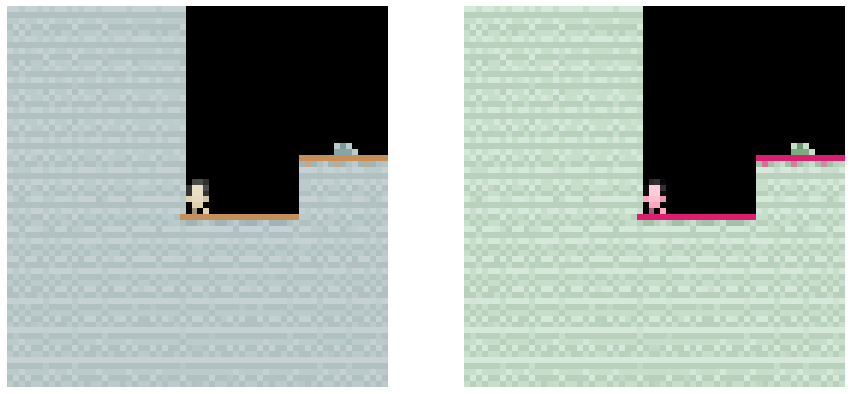

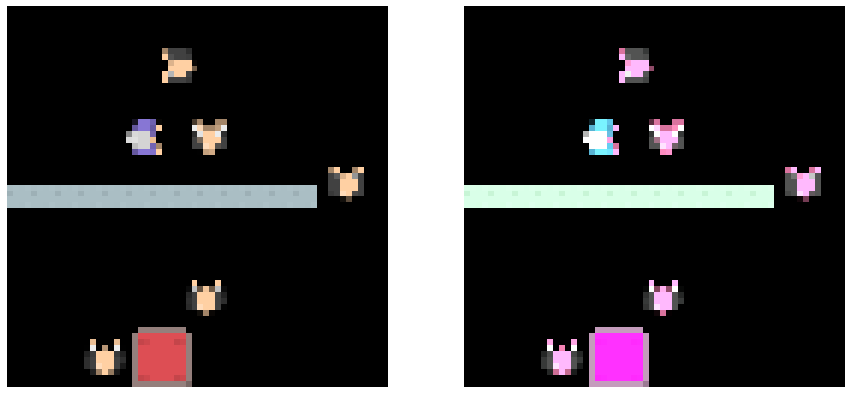

In [ ]:
# env = make_env(num_envs, num_levels=num_levels, env_name='coinrun')
# nenv = env.num_envs # added
# obs = np.zeros((nenv,) + env.observation_space.shape, dtype=env.observation_space.dtype.name)
# obs[:] = env.reset()
for game in games:
    env = make_env(num_envs, num_levels=num_levels, env_name=game)
    obs = env.reset()

    sample = obs[0,:,:,:]

    #  Plot the original observation
    plt.figure(figsize=(15,15))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(np.transpose(sample, (1, 2, 0)));

    # Do the augmentation
    obs = random_color_jitter(obs,p=1)

    # Plot the augmented
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(np.transpose(sample, (1, 2, 0)));
    # plt.show()
    plt.savefig(f'{path}color_jitter{game}.png')

# Random cutout in every observation




In [ ]:
# This is not an inplacement function like the others 

device = torch.device('cpu')
def random_cutout(imgs, min_cut,max_cut):
    """
        args:
        imgs: shape (B,C,H,W)
        out: output size (e.g. 84)
    """
    n, c, h, w = imgs.shape
    w1 = np.random.randint(min_cut, max_cut, n)
    h1 = np.random.randint(min_cut, max_cut, n)
    
    cutouts = np.empty((n, c, h, w), dtype=imgs.dtype)
    for i, (img, w11, h11) in enumerate(zip(imgs, w1, h1)):
        cut_img = img.copy()
        cut_img[:, h11:h11 + h11, w11:w11 + w11] = 0
        #print(img[:, h11:h11 + h11, w11:w11 + w11].shape)
        cutouts[i] = cut_img
    return cutouts

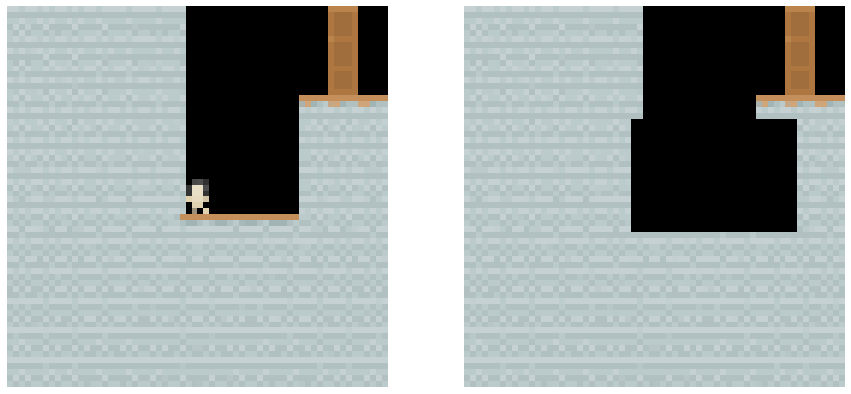

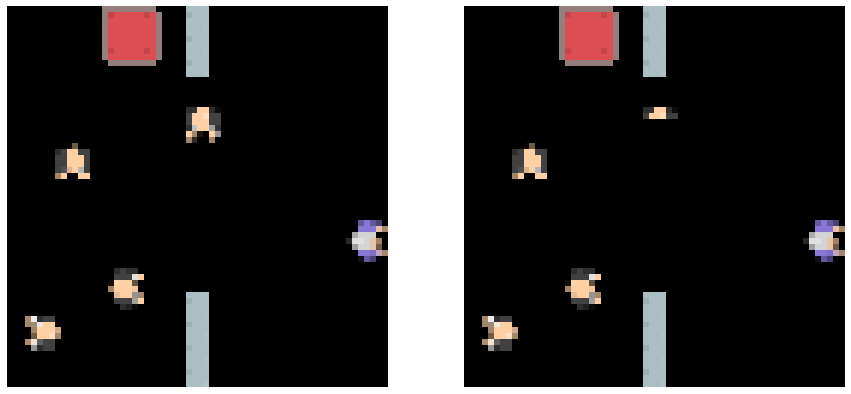

In [ ]:
for game in games:
    env = make_env(num_envs, num_levels=num_levels, env_name=game)
    nenv = env.num_envs # added
    obs = np.zeros((nenv,) + env.observation_space.shape, dtype=env.observation_space.dtype.name)
    obs[:] = env.reset()
    sample = obs[0,:,:,:]

    #  Plot the original observation
    plt.figure(figsize=(15,15))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    plt.imshow(np.transpose(sample, (1, 2, 0)));

    # Do the augmentation
    obs = random_cutout(obs,16,32)
    sample = obs[0,:,:,:]

    # Plot the augmented
    plt.subplot(1, 2, 2)
    plt.axis('off')
    plt.imshow(np.transpose(sample, (1, 2, 0)));
    # plt.show()
    plt.savefig(f'{path}rand_cutout{game}.png')

In [ ]:
# Snippet of code to run numpy array as obs or as tensor

# As the regular tensor setup
# env = make_env(num_envs, num_levels=num_levels, env_name='coinrun')
# obs = env.reset()

# As numpy array
# env = make_env(num_envs, num_levels=num_levels, env_name='coinrun')
# nenv = env.num_envs # added
# obs = np.zeros((nenv,) + env.observation_space.shape, dtype=env.observation_space.dtype.name)
# obs[:] = env.reset()

# Mixreg

In [ ]:
# Hyperparameters
total_steps = 1e4 # 8e6
num_envs = 32 # 32
num_levels = 100 # 10
num_steps = 256 # 256
num_epochs = 3 # 3
batch_size = 512 # 512
eps = .2 # .2
grad_eps = .5 # .5
value_coef = .5 # .5
entropy_coef = .01 # .01

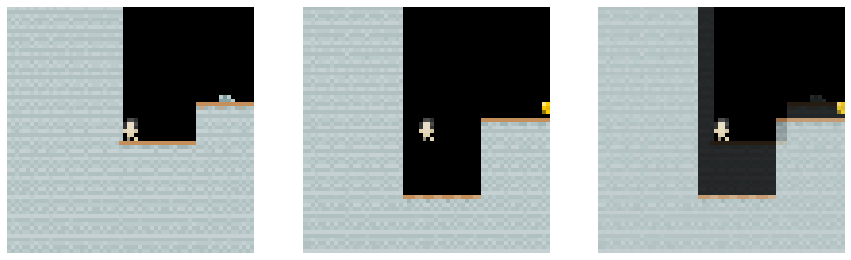

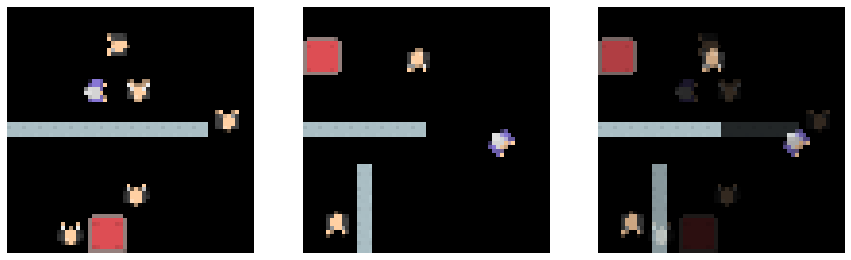

In [ ]:
num_levels = 10
for game in games:
  env_1 = make_env(1, num_levels=10, env_name=game)
  num_actions = env.action_space.n
  obs = env_1.reset()
  sample = obs[0,:,:,:]

  plt.figure(figsize=(15,15))
  plt.subplot(1, 3, 1)
  plt.axis('off')
  plt.imshow(np.transpose(sample, (1, 2, 0)));

  env_2 = make_env(1, start_level=20, num_levels=10, env_name=game)
  num_actions = env.action_space.n
  obs = env_2.reset()

  for x in range(20):
    action = random.randint(1, num_actions)
    action = torch.tensor((action,), dtype=torch.int32)
    # action = np.int32(action)
    obs, reward, done, info = env_2.step(action)

  plt.subplot(1, 3, 2)
  plt.axis('off')
  sample_2 = obs[0,:,:,:]
  plt.imshow(np.transpose(sample_2, (1, 2, 0)));


  plt.subplot(1, 3, 3)
  plt.axis('off')
  new_obs = sample*0.2 + sample_2*0.8
  plt.imshow(np.transpose(new_obs, (1, 2, 0)));
  plt.savefig(f'{path}mixreg{game}.png')